In [ ]:
from i308_calib import *
from i308_utils import *
import cv2
import pickle
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
from disparity.method_cre_stereo import CREStereo
from disparity.methods import Calibration, InputPair, Config
import numpy as np

sys.path.append(os.path.abspath(os.path.join("..", "src")))
from calibration_funcs import *
from rectification_funcs import *
from disparity_funcs import *


%load_ext autoreload
%autoreload 2

In [2]:
with open("../datasets/budha_board/calibration_results/stereo_calibration.pkl", "rb") as f:
    calibration_results = pickle.load(f)

In [3]:
with open("../datasets/budha_board/rectification_results/stereo_rectification.pkl", "rb") as f:
    rectification_results = pickle.load(f)

In [4]:
print(calibration_results.keys())
print(rectification_results.keys())

dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])
dict_keys(['R1', 'R2', 'P1', 'P2', 'Q', 'validRoi1', 'validRoi2', 'left_map_x', 'left_map_y', 'right_map_x', 'right_map_y'])


In [6]:
path = "../datasets/budha_board/rectified_captures"
left_images, right_images = get_images(path, prefix="", ext="jpg", print_info=True)
left_gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in left_images]
right_gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in right_images]


Found 6 left images and 6 right images
First left image: ..\datasets\budha_board\rectified_captures\left_rectified_0.jpg
First right image: ..\datasets\budha_board\rectified_captures\right_rectified_0.jpg


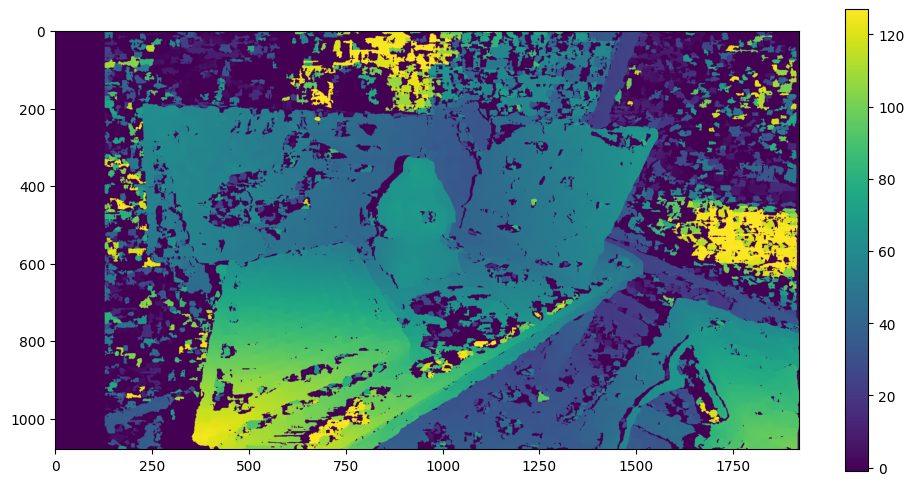

In [ ]:
idx= 0

stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=128,          
    blockSize=19,                  
    P1=648,
    P2=1443,
    uniquenessRatio=4,
    speckleWindowSize=100,
    speckleRange=9,
    disp12MaxDiff=1,
    preFilterCap=11,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

disparity_map = stereo.compute(
    left_gray_images[idx],
    right_gray_images[idx]
).astype(np.float32) / 16.0

plt.figure(figsize=(12, 6))
plt.imshow(disparity_map)
plt.colorbar()
plt.show()

In [ ]:
w, h = left_images[idx].shape[1], left_images[idx].shape[0]

left_K = calibration_results["left_K"]
fx = left_K[0][0]
fy = left_K[1][1]
cx0 = left_K[0][2]
cy0 = left_K[1][2]
T = calibration_results["T"]
baseline = np.linalg.norm(T)

calibration = Calibration(**{
    "width": w,
    "height": h,
    "baseline_meters": baseline / 1000,
    "fx": fx,
    "fy": fy,
    "cx0": cx0,
    "cx1": cx0,
    "cy": cy0,
    "depth_range": [0.05, 20.0],
    "left_image_rect_normalized": [0, 0, 1, 1]
})

In [ ]:
models_path = "models"
if not os.path.exists(models_path):
    os.makedirs(models_path)

models_path = Path.home() / ".cache" / "stereodemo" / "models"
models_path = Path(models_path)

left_rgb = cv2.cvtColor(left_images[idx], cv2.COLOR_BGR2RGB)
right_rgb = cv2.cvtColor(right_images[idx], cv2.COLOR_BGR2RGB)
pair = InputPair(left_rgb, right_rgb, calibration)
config = Config(models_path=models_path)

method = CREStereo(config)

method.parameters["Shape"].set_value("1280x720")
method.parameters["Mode"].set_value("combined")
method.parameters["Iterations"].set_value("10")
disparity = method.compute_disparity(pair)

C:\Users\Lucio\.cache\stereodemo\models\crestereo_combined_iter10_720x1280.onnx


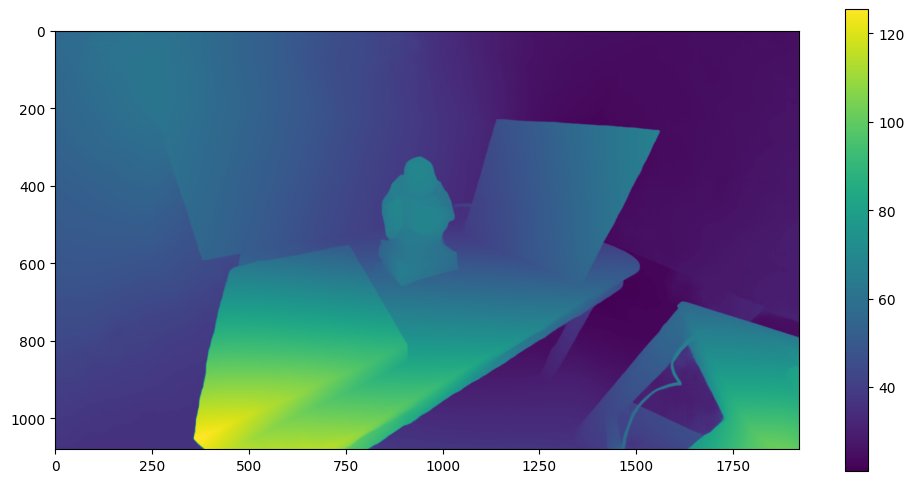

In [10]:
plt.figure(figsize=(12, 6))
plt.imshow(disparity.disparity_pixels)
plt.colorbar()
plt.show()

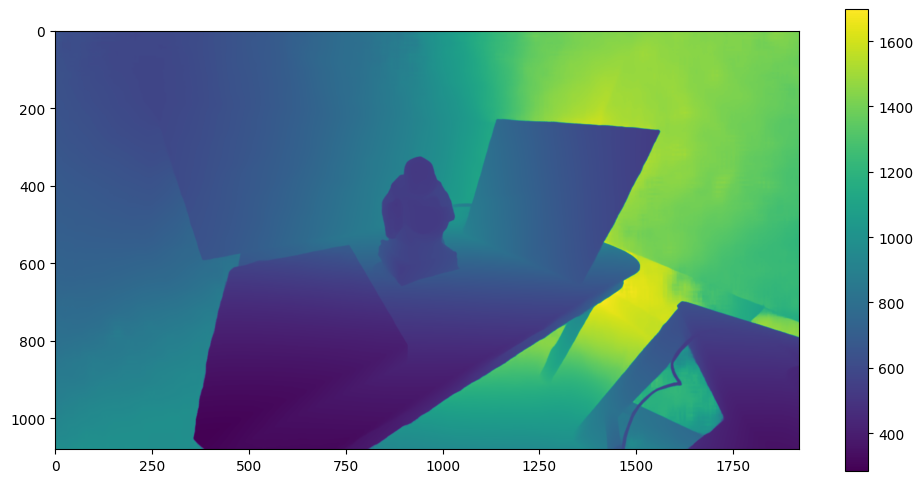

In [12]:
disparity_map = disparity.disparity_pixels

f = left_K[0][0]
B = np.linalg.norm(T) 

depth = compute_depth(disparity_map, f, B)

plt.figure(figsize=(12, 6))
plt.imshow(depth)
plt.colorbar()
plt.show()

In [14]:
disparities = get_disparity_images(left_images, right_images, calibration_results)

C:\Users\Lucio\.cache\stereodemo\models\crestereo_combined_iter10_720x1280.onnx
C:\Users\Lucio\.cache\stereodemo\models\crestereo_combined_iter10_720x1280.onnx
C:\Users\Lucio\.cache\stereodemo\models\crestereo_combined_iter10_720x1280.onnx
C:\Users\Lucio\.cache\stereodemo\models\crestereo_combined_iter10_720x1280.onnx
C:\Users\Lucio\.cache\stereodemo\models\crestereo_combined_iter10_720x1280.onnx
C:\Users\Lucio\.cache\stereodemo\models\crestereo_combined_iter10_720x1280.onnx


In [17]:
path = "../datasets/budha_board/disparities/disparities.pkl"
with open(path, "wb") as f:
    pickle.dump(disparities, f)